# Assignment 7: Experiment using MLE and PyMC3

## Team Members:
## 1) Sanket Khadke
## 2) Ujjanth Arhan

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing the necessary libraries

import numpy as np
import pandas as pd
import seaborn as sns
import math as ma

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
from pymc3 import StudentT, Normal
from pymc3 import Model, Uniform
from pymc3 import Exponential
from pymc3 import fit

from arviz import plot_posterior

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl
WARN: Could not locate executable gfortran
WARN: Could not locate executable f95
WARN: Could not locate executable g95
WARN: Could not locate executable efort
WARN: Could not locate executable efc
WARN: Could not locate executable flang
WARN: don't know how to compile Fortran code on platform 'nt'


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## We are using the 'Forest Fires' dataset which contains various information on the meteorological data in the region of Portugal.

## The dataset is the file named "forest_fire_dataset.csv" present in the parent directory.

In [3]:
# Reading the dataset using pandas

forest_fire_df = pd.read_csv("forest_fire_dataset.csv")

In [4]:
# Displaying the first 15 rows

forest_fire_df.head(15)

x-axis  y-axis      month day_of_week  FFMC_index  DMC_index  DC_index  \
0        7       5      March      Friday        86.2       26.2      94.3   
1        7       4    October     Tuesday        90.6       35.4     669.1   
2        7       4    October    Saturday        90.6       43.7     686.9   
3        8       6      March      Friday        91.7       33.3      77.5   
4        8       6      March      Sunday        89.3       51.3     102.2   
5        8       6     August      Sunday        92.3       85.3     488.0   
6        8       6     August      Monday        92.3       88.9     495.6   
7        8       6     August      Monday        91.5      145.4     608.2   
8        8       6  September     Tuesday        91.0      129.5     692.6   
9        7       5  September    Saturday        92.5       88.0     698.6   
10       7       5  September    Saturday        92.5       88.0     698.6   
11       7       5  September    Saturday        92.8       73.2     713.0   
12       6       5     August      Friday        63.5       70.8     665.3   
13       6       5  September      Monday        90.9      126.5     686.5   
14       6       5  September   Wednesday        92.9      133.3     699.6   

    ISI_index  temperature  relative_humidity  wind_speed  rain  burnt_area  
0         5.1          8.2                 51         6.7   0.0         0.0  
1         6.7         18.0                 33         0.9   0.0         0.0  
2         6.7         14.6                 33         1.3   0.0         0.0  
3         9.0          8.3                 97         4.0   0.2         0.0  
4         9.6         11.4                 99         1.8   0.0         0.0  
5        14.7         22.2                 29         5.4   0.0         0.0  
6         8.5         24.1                 27         3.1   0.0         0.0  
7        10.7          8.0                 86         2.2   0.0         0.0  
8         7.0         13.1                 63         5.4   0.0         0.0  
9         7.1         22.8                 40         4.0   0.0         0.0  
10        7.1         17.8                 51         7.2   0.0         0.0  
11       22.6         19.3                 38         4.0   0.0         0.0  
12        0.8         17.0                 72         6.7   0.0         0.0  
13        7.0         21.3                 42         2.2   0.0         0.0  
14        9.2         26.4                 21         4.5   0.0         0.0

## If we take a look at the relative_humidity column - It shows the percentage of relative humidity that was present on a particular day.

<AxesSubplot: >

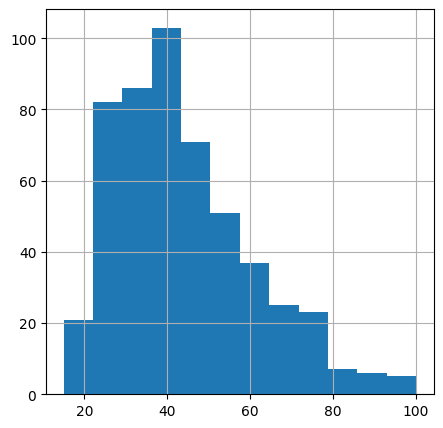

In [5]:
# Plotting a histogram for the relative humidity column

forest_fire_df.relative_humidity.hist(figsize = (5, 5), bins = 12)

## We consider the "relative_humidity" column for our calculations.

In [6]:
# The relative_humidity_col contains the "relative_humidity" column from our forest_fire_df dataframe

relative_humidity_col = forest_fire_df.relative_humidity

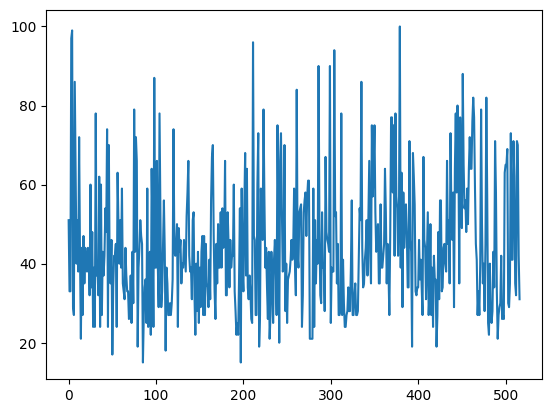

In [7]:
# Plotting the relative humidity column

plt.plot(relative_humidity_col)

## Computing the histogram

Text(0.5, 0, 'Relative Humidity')

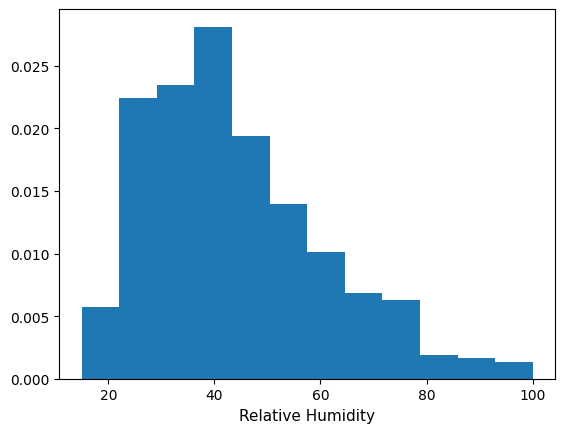

In [8]:
# Plotting the histogram of the relative humidity column using matplotlib

plt.hist(relative_humidity_col, bins = 12, density = True)
plt.xlabel('Relative Humidity', fontsize = 11)

# Finding best possible match using MLE:

## Now, we need to test which distribution fits our dataset.

## If we try to fit the gamma distribution to the relative humidity column, we get below result-

<AxesSubplot: xlabel='relative_humidity'>

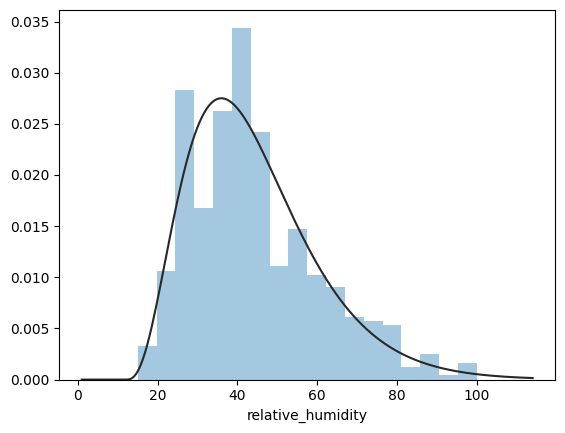

In [9]:
# Visualizing the distribution of data

sns.distplot(relative_humidity_col, kde = False, fit = stats.gamma)

## As it can be seen above from the graph, the tail is right-skewed.
### Thus, a gamma distribution can be perfectly fit for this dataset.
### Thus, we need to calculate its parameters using MLE.
### These parameters would be the α and β.

In [10]:
# Importing necessary libraries from scipy

from scipy.optimize import newton
from scipy.special import psi, polygamma

# Calculating the derivatives of gammaln function
# log_of_mean and mean_of_log are parameters for the dlgamma function

dlgamma1 = lambda x, log_of_mean, mean_of_log: np.log(x) - psi(x) - log_of_mean + mean_of_log

dlgamma2 = lambda x, *args: 1./x - polygamma(1, x)

In [11]:
# Calculating the log of the mean of relative humidity column using the log() method from math module

log = ma.log(relative_humidity_col.mean())

In [12]:
# Calculating the mean of the log

mean_of_log = relative_humidity_col.apply(np.log).mean()

In [13]:
# Now, we calculate the α and β parameters -
# For calculating the α parameter,
# We pass the "log" and "mean_of_log" calculated above as tuple of arguments to the newton method -

alpha_mle_parameter = newton(dlgamma1, 2, dlgamma2, args = (log, mean_of_log))

beta_mle_parameter = alpha_mle_parameter / relative_humidity_col.mean()

alpha_mle_parameter, beta_mle_parameter

(7.854274572489745, 0.17734462829092013)

## Thus, the required best parameters are α parameter = 7.85 and the β parameter = 0.17 as calculated above.

Text(0.5, 0, 'Relative Humidity')

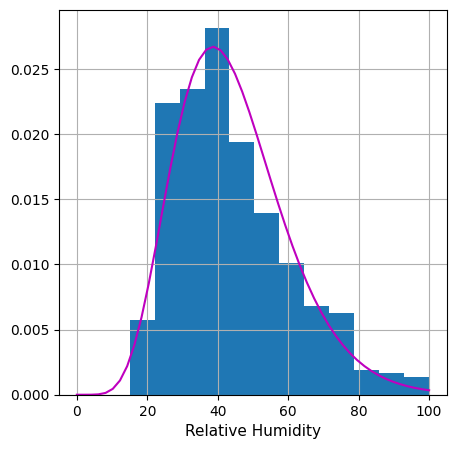

In [14]:
from scipy.stats.distributions import gamma

relative_humidity_col.hist(density = True, figsize = (5, 5), bins = 12)

# y contains evenly spaced values from 0 to the maximum of relative humidity

y = np.linspace(0, relative_humidity_col.max())

# Using the α and β parameters calculated above as parameters for plotting gamma distribution

# Passing alpha_mle_parameter as the shape parameter (a)
# Passing beta_mle_parameter as the scale parameter (scale)

plt.plot(y, gamma.pdf(y, a = alpha_mle_parameter, scale = 1 / beta_mle_parameter), 'm-')
plt.xlabel('Relative Humidity', fontsize = 11)

In [15]:
from scipy.stats import gamma

# The fit() method returns the estimates of shape, location and scale parameters

gamma.fit(relative_humidity_col)

(3.8681822019871803, 12.09884960748013, 8.321576470272174)

# Performing the same experiment with Bayesian simulation using PyMC3

## We first need to calculate the mean and the standard deviation -

In [16]:
mean = relative_humidity_col.mean()

In [17]:
print ("Mean of Relative Humidity: ", mean)

Mean of Relative Humidity:  44.28820116054158


In [18]:
standard_dev = relative_humidity_col.std()

In [19]:
print ("Standard Deviation of Relative Humidity: ", standard_dev)

Standard Deviation of Relative Humidity:  16.31746923937841


## The mean and standard_dev calculated above are used to model the data.

In [20]:
with Model() as relative_humidity_model:
    μ = Normal('μ', mean, sd = standard_dev)

In [21]:
with relative_humidity_model:
    σ = Uniform('σ', lower = 0, upper = 20)

In [22]:
with relative_humidity_model:
    ν = Exponential('ν_minus_one', 1 / 29.) + 1

In [23]:
with relative_humidity_model:
    relative_humidity_like = StudentT('relative_humidity_like', nu = ν, mu = μ, lam = σ**-2, observed = relative_humidity_col)

In [24]:
# We define a random seed

RANDOM_SEED = 20222110

## Now, we fit the relative humidity model using variational inference -

In [25]:
with relative_humidity_model: 
    relative_humidity_trace = fit(random_seed = RANDOM_SEED).sample(1000)

Finished [100%]: Average Loss = 2,182.2


## We throw away the first 100 samples and plot all the posterior distributions.

In [26]:
plot_posterior (relative_humidity_trace[100:], 
                var_names = ['μ', 'σ', 'ν_minus_one'],
                color = '#87ceeb');

Got error No model on context stack. trying to find log_likelihood in translation.


## Now, we plot the gamma pdf distribution v/s the distribution from the StudentT model.

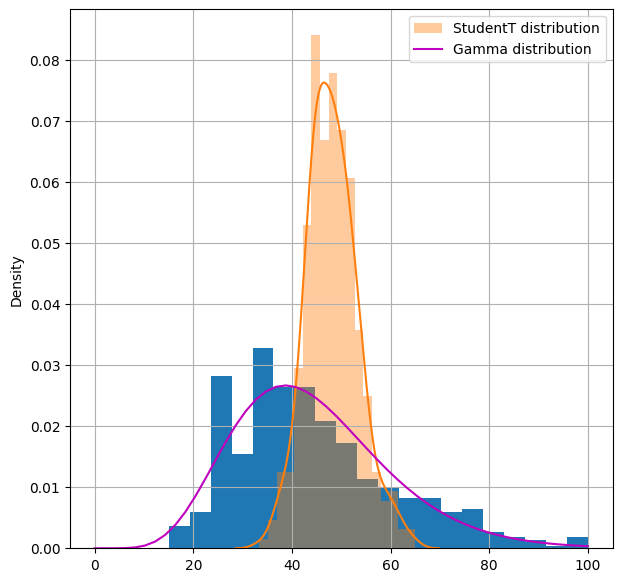

In [27]:
# Plotting histogram of the relative humidity column

relative_humidity_col.hist(density = True, figsize = (7, 7), bins = 20)

# StudentT is imported from the PyMC3 package above
# Using the dist() method of StudentT to create a distribution

# We assume the following values for nu, mu and lam for the StudentT distribution through estimation

t = StudentT.dist(nu = 21, mu = 48, lam = 5**-2).random(size = 365)

# Plotting the graph using StudentT distribution

sns.distplot(t, label = 'StudentT distribution')

# Plotting the gamma distribution
# y is calculated above as evenly spaced values from 0 to the maximum of relative humidity

# Passing alpha_mle_parameter as the shape parameter (a)
# Passing beta_mle_parameter as the scale parameter (scale) in the pdf() method as -

plt.plot(y, gamma.pdf(y, a = alpha_mle_parameter, scale = 1 / beta_mle_parameter), 'm-', label = 'Gamma distribution')
plt.legend()

## Thus, we have plotted the gamma distribution and Student-T distribution.

## The above graph shows a plot of estimation using MLE v/s PyMC3. 

# Which method is more correct?

## Use of method depends upon following factors -
## 1) Type of dataset being used
## 2) Central value of the probability distribution

## Depending upon the above factors, either MLE or PyMC3 can be suitable to use.